In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

from scipy.stats import shapiro

from statsmodels.stats.outliers_influence import variance_inflation_factor

from skopt import gp_minimize
from skopt.space import Real, Integer

In [2]:
Teams = pd.read_csv('cleanTeams.csv')
OPS = pd.read_csv('OPS_Data.csv')

In [3]:
# Removing double index column
Teams = Teams.drop("Unnamed: 0", axis=1)

In [4]:
Teams['1B'] = Teams['H'] - Teams['2B'] - Teams['3B'] - Teams['HR']

## Adding in missing OPS data from 1951-1969

In [5]:
# Adding the missing OPS data from mlb.com (mined using beatufulsoup)
OPS

,Year,Team,OPS,OBP
0,1951,Brooklyn Dodgers,0.786,0.352
1,1951,New York Giants,0.765,0.347
2,1951,New York Yankees,0.757,0.349
3,1951,Boston Red Sox,0.750,0.358
4,1951,Philadelphia Athletics,0.735,0.349
...,...,...,...,...
4375,1973,Texas Rangers,0.679,0.318
4376,1973,Chicago Cubs,0.677,0.320
4377,1973,California Angels,0.666,0.318
4378,1973,New York Mets,0.653,0.315


In [6]:
OPS = OPS.rename(columns={'Year': 'yearID', 'Team': 'name'})

In [7]:
OPS

,yearID,name,OPS,OBP
0,1951,Brooklyn Dodgers,0.786,0.352
1,1951,New York Giants,0.765,0.347
2,1951,New York Yankees,0.757,0.349
3,1951,Boston Red Sox,0.750,0.358
4,1951,Philadelphia Athletics,0.735,0.349
...,...,...,...,...
4375,1973,Texas Rangers,0.679,0.318
4376,1973,Chicago Cubs,0.677,0.320
4377,1973,California Angels,0.666,0.318
4378,1973,New York Mets,0.653,0.315


In [8]:
# Note the only year the MLB played less than 100 games was 2020, this year will be removed from the Teams dataframe
Teams.loc[Teams['G'] < 100]

,yearID,lgID,teamID,franchID,divID,Rank,G,Ghome,W,L,...,BPF,PPF,teamIDBR,teamIDlahman45,teamIDretro,OBP,TB,SLG,OPS,1B
1698,2020,NL,ARI,ARI,W,5,60,30.0,25,35,...,102,102,ARI,ARI,ARI,0.312472,781,0.391087,0.703559,311
1699,2020,NL,ATL,ATL,E,1,60,30.0,35,25,...,107,106,ATL,ATL,ATL,0.349125,1001,0.482642,0.831767,320
1700,2020,AL,BAL,BAL,E,4,60,33.0,25,35,...,100,102,BAL,BAL,BAL,0.320611,870,0.429418,0.750028,337
1701,2020,AL,BOS,BOS,E,5,60,31.0,24,36,...,105,105,BOS,BOS,BOS,0.330435,927,0.445031,0.775466,346
1702,2020,AL,CHA,CHW,C,2,60,30.0,35,25,...,99,100,CHW,CHA,CHA,0.325674,928,0.453346,0.779020,338
1703,2020,NL,CHN,CHC,C,1,60,33.0,34,26,...,100,99,CHC,CHN,CHN,0.317812,742,0.386861,0.704673,258
1704,2020,NL,CIN,CIN,C,2,60,29.0,31,29,...,106,106,CIN,CIN,CIN,0.312117,742,0.402823,0.714940,221
1705,2020,AL,CLE,CLE,C,2,60,30.0,35,25,...,104,103,CLE,CLE,CLE,0.316801,729,0.372129,0.688929,286
1706,2020,NL,COL,COL,W,4,60,30.0,26,34,...,116,117,COL,COL,COL,0.311081,833,0.404959,0.716040,365
1707,2020,AL,DET,DET,C,5,58,27.0,23,35,...,102,105,DET,DET,DET,0.303425,751,0.396725,0.700150,311


In [9]:
# Drop all rows where yearID is 2020
Teams = Teams.drop(Teams[Teams.yearID == 2020].index)

In [10]:
# Merge the Teams and OPS data on matching conditions and update the Teams data
Teams = Teams.fillna(OPS)

In [11]:
Teams

,yearID,lgID,teamID,franchID,divID,Rank,G,Ghome,W,L,...,BPF,PPF,teamIDBR,teamIDlahman45,teamIDretro,OBP,TB,SLG,OPS,1B
0,1951,AL,BOS,BOS,NaN,3,154,75.0,87,67,...,110,109,BOS,BOS,BOS,0.352000,2106,0.391595,0.786000,1036
1,1951,NL,BRO,LAD,NaN,2,158,78.0,97,60,...,102,99,BRO,BRO,BRO,0.347000,2386,0.434450,0.765000,1041
2,1951,NL,BSN,ATL,NaN,4,155,78.0,76,78,...,93,93,BSN,BSN,BSN,0.349000,2083,0.393539,0.757000,984
3,1951,AL,CHA,CHW,NaN,4,155,78.0,81,73,...,98,98,CHW,CHA,CHA,0.358000,2068,0.384530,0.750000,1074
4,1951,NL,CHN,CHC,NaN,8,155,77.0,62,92,...,102,104,CHC,CHN,CHN,0.349000,1930,0.363671,0.735000,977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1753,2021,NL,SLN,STL,C,2,162,81.0,90,72,...,92,92,STL,SLN,SLN,0.313308,2202,0.411512,0.724819,822
1754,2021,AL,TBA,TBD,E,1,162,81.0,100,62,...,92,91,TBR,TBA,TBA,0.321193,2362,0.428909,0.750101,790
1755,2021,AL,TEX,TEX,W,5,162,81.0,60,102,...,99,101,TEX,TEX,TEX,0.294415,2028,0.375208,0.669624,838
1756,2021,AL,TOR,TOR,E,4,162,80.0,91,71,...,102,101,TOR,TOR,TOR,0.330472,2552,0.466034,0.796506,895


In [12]:
# Filling all null values with the mean for that column
mean_values = Teams.mean()
Teams = Teams.fillna(mean_values)

<ipython-input-12-a1c4e51fbeb0>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean_values = Teams.mean()


In [13]:
# Copying Temas DF and Dropping irrelevent columns for the model
mainDF = Teams.copy()
mainDF = mainDF.drop(["attendance", "yearID", "teamID", "lgID", "franchID", "divID", 
                      "teamIDBR", "teamIDlahman45", "teamIDretro", "name", "SHO", 
                      "IPouts", "park", 'Ghome', 'CG', 'DivWin'], axis=1)

mainDF[['LgWin', 'WSWin']] = mainDF[['LgWin', 'WSWin']].replace({'N': 0, 'Y': 1})

In [14]:
mainDF.to_csv('modelDF.csv')

In [15]:
mainDF.T

,0,1,2,3,4,5,6,7,8,9,...,1748,1749,1750,1751,1752,1753,1754,1755,1756,1757
Rank,3.000000,2.000000,4.000000,4.000000,8.000000,6.000000,2.000000,5.000000,1.000000,1.000000,...,2.000000,5.000000,3.000000,2.000000,1.000000,2.000000,1.000000,5.000000,4.000000,5.000000
G,154.000000,158.000000,155.000000,155.000000,155.000000,155.000000,155.000000,154.000000,157.000000,154.000000,...,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000
W,87.000000,97.000000,76.000000,81.000000,62.000000,68.000000,93.000000,73.000000,98.000000,98.000000,...,82.000000,61.000000,79.000000,90.000000,107.000000,90.000000,100.000000,60.000000,91.000000,65.000000
L,67.000000,60.000000,78.000000,73.000000,92.000000,86.000000,61.000000,81.000000,59.000000,56.000000,...,80.000000,101.000000,83.000000,72.000000,55.000000,72.000000,62.000000,102.000000,71.000000,97.000000
LgWin,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
WSWin,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
R,804.000000,855.000000,723.000000,714.000000,614.000000,559.000000,696.000000,685.000000,781.000000,798.000000,...,734.000000,609.000000,729.000000,697.000000,804.000000,706.000000,857.000000,625.000000,846.000000,724.000000
AB,5378.000000,5492.000000,5293.000000,5378.000000,5307.000000,5285.000000,5250.000000,5336.000000,5360.000000,5194.000000,...,5366.000000,5336.000000,5384.000000,5355.000000,5462.000000,5351.000000,5507.000000,5405.000000,5476.000000,5385.000000
H,1428.000000,1511.000000,1385.000000,1453.000000,1327.000000,1309.000000,1346.000000,1413.000000,1396.000000,1395.000000,...,1288.000000,1261.000000,1305.000000,1209.000000,1360.000000,1303.000000,1336.000000,1254.000000,1455.000000,1388.000000
2B,233.000000,249.000000,234.000000,229.000000,200.000000,215.000000,208.000000,231.000000,201.000000,208.000000,...,262.000000,240.000000,273.000000,233.000000,271.000000,261.000000,288.000000,225.000000,285.000000,272.000000


In [16]:
# Applying park factors
# Define the columns to apply park factors to
factoredDF = mainDF.copy()

pitcher_cols = ['ERA', 'HRA', 'ER', 'HA', 'RA', 'SOA']
batter_cols = ['R', 'H', '1B', '2B', '3B', 'HR', 'OPS', 'OBP', 'SLG', 'TB']

# Apply the park factor to the pitcher columns
factoredDF[pitcher_cols] = factoredDF[pitcher_cols].apply(lambda x: x * factoredDF['PPF'])

# Apply the park factor to the batter columns
factoredDF[batter_cols] = factoredDF[batter_cols].apply(lambda x: x * factoredDF['BPF'])

# Print the resulting DataFrame
factoredDF = factoredDF.drop(["BPF", "PPF"], axis=1)
factoredDF.T

,0,1,2,3,4,5,6,7,8,9,...,1748,1749,1750,1751,1752,1753,1754,1755,1756,1757
Rank,3.000000,2.000000,4.000000,4.000000,8.000000,6.000000,2.000000,5.000000,1.000000,1.000000,...,2.000000,5.000000,3.000000,2.000000,1.000000,2.000000,1.000000,5.000000,4.000000,5.000000
G,154.000000,158.000000,155.000000,155.000000,155.000000,155.000000,155.000000,154.000000,157.000000,154.000000,...,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000
W,87.000000,97.000000,76.000000,81.000000,62.000000,68.000000,93.000000,73.000000,98.000000,98.000000,...,82.000000,61.000000,79.000000,90.000000,107.000000,90.000000,100.000000,60.000000,91.000000,65.000000
L,67.000000,60.000000,78.000000,73.000000,92.000000,86.000000,61.000000,81.000000,59.000000,56.000000,...,80.000000,101.000000,83.000000,72.000000,55.000000,72.000000,62.000000,102.000000,71.000000,97.000000
LgWin,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
WSWin,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
R,88440.000000,87210.000000,67239.000000,69972.000000,62628.000000,56459.000000,66120.000000,68500.000000,78881.000000,77406.000000,...,72666.000000,59682.000000,67068.000000,66215.000000,78792.000000,64952.000000,78844.000000,61875.000000,86292.000000,68780.000000
AB,5378.000000,5492.000000,5293.000000,5378.000000,5307.000000,5285.000000,5250.000000,5336.000000,5360.000000,5194.000000,...,5366.000000,5336.000000,5384.000000,5355.000000,5462.000000,5351.000000,5507.000000,5405.000000,5476.000000,5385.000000
H,157080.000000,154122.000000,128805.000000,142394.000000,135354.000000,132209.000000,127870.000000,141300.000000,140996.000000,135315.000000,...,127512.000000,123578.000000,120060.000000,114855.000000,133280.000000,119876.000000,122912.000000,124146.000000,148410.000000,131860.000000
2B,25630.000000,25398.000000,21762.000000,22442.000000,20400.000000,21715.000000,19760.000000,23100.000000,20301.000000,20176.000000,...,25938.000000,23520.000000,25116.000000,22135.000000,26558.000000,24012.000000,26496.000000,22275.000000,29070.000000,25840.000000


In [17]:
# Scale the data between 0 and 1
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(factoredDF)

In [18]:
scaledDF = pd.DataFrame(scaled_data, columns=factoredDF.columns)

In [19]:
scaledDF.to_csv('scaledDF.csv')

In [20]:
scaledDF.T

,0,1,2,3,4,5,6,7,8,9,...,1718,1719,1720,1721,1722,1723,1724,1725,1726,1727
Rank,0.222222,0.111111,0.333333,0.333333,0.777778,0.555556,0.111111,0.444444,0.000000,0.000000,...,0.111111,0.444444,0.222222,0.111111,0.000000,0.111111,0.000000,0.444444,0.333333,0.444444
G,0.822581,0.887097,0.838710,0.838710,0.838710,0.838710,0.838710,0.822581,0.870968,0.822581,...,0.951613,0.951613,0.951613,0.951613,0.951613,0.951613,0.951613,0.951613,0.951613,0.951613
W,0.632911,0.759494,0.493671,0.556962,0.316456,0.392405,0.708861,0.455696,0.772152,0.772152,...,0.569620,0.303797,0.531646,0.670886,0.886076,0.670886,0.797468,0.291139,0.683544,0.354430
L,0.320513,0.230769,0.461538,0.397436,0.641026,0.564103,0.243590,0.500000,0.217949,0.179487,...,0.487179,0.756410,0.525641,0.384615,0.166667,0.384615,0.256410,0.769231,0.371795,0.705128
LgWin,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
WSWin,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
R,0.625299,0.611144,0.381318,0.412769,0.328254,0.257262,0.368440,0.395829,0.515294,0.498320,...,0.443772,0.294352,0.379350,0.369534,0.514270,0.354999,0.514868,0.319589,0.600580,0.399052
AB,0.823864,0.873689,0.786713,0.823864,0.792832,0.783217,0.767920,0.805507,0.815997,0.743444,...,0.818619,0.805507,0.826486,0.813811,0.860577,0.812063,0.880245,0.835664,0.866696,0.826923
H,0.584027,0.560230,0.356564,0.465883,0.409248,0.383948,0.349042,0.457082,0.454636,0.408934,...,0.346162,0.314514,0.286213,0.244341,0.392564,0.284733,0.309156,0.319084,0.514279,0.381140
2B,0.494170,0.486167,0.360735,0.384193,0.313751,0.359114,0.291672,0.406893,0.310335,0.306023,...,0.504795,0.421381,0.476439,0.373603,0.526183,0.438354,0.524044,0.378432,0.612840,0.501414


In [21]:
#----------------------------------------------TESTING BLOCK------------------------------------------
# not scaling my data
#scaledDF = factoredDF
#---------------------------------------------DETETE LATER------------------------------------------------

## Model 1: Predicting Season Rank using OLS (Ordinary Least Squares)

In [22]:
# Define the features and target variables
X = scaledDF.drop(['WSWin', 'LgWin', 'Rank', 'L', 'W'], axis=1)
y = scaledDF['Rank']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [23]:
X_train = X_train.reset_index(drop=True)

In [24]:
# Fit a linear regression model using OLS
model = sm.OLS(y_train, sm.add_constant(X_train)).fit()

In [25]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Rank   R-squared:                       0.705
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     120.0
Date:                Mon, 20 Mar 2023   Prob (F-statistic):               0.00
Time:                        12:59:19   Log-Likelihood:                 986.50
No. Observations:                1382   AIC:                            -1917.
Df Residuals:                    1354   BIC:                            -1771.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4421      0.177      2.499      0.013       0.095       0.789
G              0.2123      0.140      1.516      0.130      -0.062       0.487
R             -1.2837      0.125    -10.275      0.000      -1.529      -1.039
AB            -0.5092      0.371     -1.373      0.170      -1.237       0.218
H              0.4791      0.176      2.725      0.007       0.134       0.824
2B             0.4085      0.134      3.058      0.002       0.146       0.671
3B             0.2831      0.063      4.521      0.000       0.160       0.406
HR             1.2083      0.292      4.141      0.000       0.636       1.781
BB            -0.0809      0.041     -1.953      0.051      -0.162       0.000
SO            -0.0554      0.044     -1.262      0.207      -0.142       0.031
SB            -0.1732      0.041     -4.208      0.000      -0.254      -0.092
CS             0.0802      0.037      2.183      0.029       0.008       0.152
HBP           -0.0230      0.028     -0.810      0.418      -0.079       0.033
SF             0.0986      0.029      3.403      0.001       0.042       0.155
RA             1.0500      0.339      3.101      0.002       0.386       1.714
ER            -2.5407      0.739     -3.436      0.001      -3.991      -1.090
ERA            2.0961      0.581      3.609      0.000       0.957       3.236
SV            -0.1656      0.027     -6.145      0.000      -0.218      -0.113
HA             0.3474      0.125      2.777      0.006       0.102       0.593
HRA            0.1048      0.060      1.755      0.079      -0.012       0.222
BBA            0.0276      0.040      0.686      0.493      -0.051       0.106
SOA            0.0073      0.046      0.158      0.874      -0.083       0.098
E             -0.1002      0.190     -0.526      0.599      -0.474       0.273
DP            -0.0301      0.031     -0.969      0.333      -0.091       0.031
FP            -0.1919      0.182     -1.056      0.291      -0.549       0.165
OBP            0.7390      0.129      5.744      0.000       0.487       0.991
TB             0.7650      0.223      3.429      0.001       0.327       1.203
SLG           -2.8930      0.703     -4.117      0.000      -4.271      -1.515
OPS           -0.2414      0.137     -1.761      0.078      -0.510       0.027
1B             0.1994      0.135      1.477      0.140      -0.066       0.464
==============================================================================
Omnibus:                       56.579   Durbin-Watson:                   2.087
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               79.749
Skew:                           0.387   Prob(JB):                     4.82e-18
Kurtosis:                       3.886   Cond. No.                     1.08e+16
==============================================================================

N

In [26]:
# Removing high p-value features
# Get the p-values of the coefficients
p_values = model.pvalues

# Filter the features based on p-values (over 0.05)
significant_features = p_values[p_values <= 0.05].index

# Drop the 'const' column if it exists
if 'const' in significant_features:
    significant_features = significant_features.drop('const')

# Create a new X matrix with only the significant features
X_filtered = X[significant_features]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2)


X_train = pd.DataFrame(X_train, columns=X_filtered.columns)
X_test = pd.DataFrame(X_test, columns=X_filtered.columns)

y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


# Print the resulting DataFrame
print(X_filtered.columns)

Index(['R', 'H', '2B', '3B', 'HR', 'SB', 'CS', 'SF', 'RA', 'ER', 'ERA', 'SV',
       'HA', 'OBP', 'TB', 'SLG'],
      dtype='object')


In [27]:
X_train = X_train.reset_index(drop=True)

model2 = sm.OLS(y_train, sm.add_constant(X_train)).fit()

In [28]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Rank   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.692
Method:                 Least Squares   F-statistic:                     208.1
Date:                Mon, 20 Mar 2023   Prob (F-statistic):               0.00
Time:                        12:59:20   Log-Likelihood:                 926.59
No. Observations:                1382   AIC:                            -1821.
Df Residuals:                    1366   BIC:                            -1737.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2160      0.027      7.923      0.000       0.163       0.269
R             -1.5235      0.096    -15.909      0.000      -1.711      -1.336
H              0.6772      0.125      5.402      0.000       0.431       0.923
2B             0.1634      0.056      2.935      0.003       0.054       0.273
3B             0.2454      0.035      6.978      0.000       0.176       0.314
HR             0.9488      0.123      7.732      0.000       0.708       1.190
SB            -0.1543      0.042     -3.683      0.000      -0.236      -0.072
CS             0.1032      0.037      2.795      0.005       0.031       0.176
SF             0.1030      0.029      3.527      0.000       0.046       0.160
RA             1.7248      0.240      7.197      0.000       1.255       2.195
ER            -3.4271      0.571     -5.999      0.000      -4.548      -2.306
ERA            2.4453      0.460      5.318      0.000       1.543       3.347
SV            -0.2142      0.027     -7.807      0.000      -0.268      -0.160
HA             0.2155      0.096      2.252      0.024       0.028       0.403
OBP            0.4998      0.062      8.086      0.000       0.379       0.621
TB             0.7594      0.115      6.619      0.000       0.534       0.985
SLG           -2.3902      0.330     -7.239      0.000      -3.038      -1.742
==============================================================================
Omnibus:                       74.753   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              116.701
Skew:                           0.443   Prob(JB):                     4.56e-26
Kurtosis:                       4.114   Cond. No.                     1.33e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.92e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [29]:
# Removing high p-value features
# Get the p-values of the coefficients
p_values = model2.pvalues

# Filter the features based on p-values
significant_features = p_values[p_values <= 0.05].index

# Drop the 'const' column if it exists
if 'const' in significant_features:
    significant_features = significant_features.drop('const')

# Create a new X matrix with only the significant features
X_filtered = X[significant_features]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2)


X_train = pd.DataFrame(X_train, columns=X_filtered.columns)
X_test = pd.DataFrame(X_test, columns=X_filtered.columns)

y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


# Print the resulting DataFrame
print(X_filtered.columns)

Index(['R', 'H', '2B', '3B', 'HR', 'SB', 'CS', 'SF', 'RA', 'ER', 'ERA', 'SV',
       'HA', 'OBP', 'TB', 'SLG'],
      dtype='object')


In [30]:
X_train = X_train.reset_index(drop=True)
model3 = sm.OLS(y_train, sm.add_constant(X_train)).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Rank   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     189.9
Date:                Mon, 20 Mar 2023   Prob (F-statistic):          7.89e-321
Time:                        12:59:20   Log-Likelihood:                 927.38
No. Observations:                1382   AIC:                            -1823.
Df Residuals:                    1366   BIC:                            -1739.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2445      0.027      9.032      0.000       0.191       0.298
R             -1.4349      0.094    -15.229      0.000      -1.620      -1.250
H              0.6244      0.122      5.128      0.000       0.386       0.863
2B             0.1697      0.055      3.097      0.002       0.062       0.277
3B             0.2139      0.034      6.254      0.000       0.147       0.281
HR             0.8279      0.119      6.976      0.000       0.595       1.061
SB            -0.1746      0.041     -4.232      0.000      -0.256      -0.094
CS             0.0876      0.037      2.390      0.017       0.016       0.160
SF             0.0770      0.029      2.641      0.008       0.020       0.134
RA             1.7827      0.239      7.472      0.000       1.315       2.251
ER            -3.3148      0.559     -5.931      0.000      -4.411      -2.218
ERA            2.2543      0.446      5.052      0.000       1.379       3.130
SV            -0.2209      0.028     -8.031      0.000      -0.275      -0.167
HA             0.2325      0.096      2.428      0.015       0.045       0.420
OBP            0.3961      0.064      6.154      0.000       0.270       0.522
TB             0.6812      0.111      6.164      0.000       0.464       0.898
SLG           -2.1078      0.320     -6.596      0.000      -2.735      -1.481
==============================================================================
Omnibus:                       75.376   Durbin-Watson:                   2.035
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              108.456
Skew:                           0.473   Prob(JB):                     2.81e-24
Kurtosis:                       3.994   Cond. No.                     2.46e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.45e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [31]:
# Removing high p-value features
# Get the p-values of the coefficients
p_values = model3.pvalues

# Filter the features based on p-values
significant_features = p_values[p_values <= 0.05].index

# Drop the 'const' column if it exists
if 'const' in significant_features:
    significant_features = significant_features.drop('const')

# Create a new X matrix with only the significant features
X_filtered = X[significant_features]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2)


X_train = pd.DataFrame(X_train, columns=X_filtered.columns)
X_test = pd.DataFrame(X_test, columns=X_filtered.columns)

y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


# Print the resulting DataFrame
print(X_filtered.columns)

Index(['R', 'H', '2B', '3B', 'HR', 'SB', 'CS', 'SF', 'RA', 'ER', 'ERA', 'SV',
       'HA', 'OBP', 'TB', 'SLG'],
      dtype='object')


In [32]:
X_train = X_train.reset_index(drop=True)
model4 = sm.OLS(y_train, sm.add_constant(X_train)).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Rank   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.692
Method:                 Least Squares   F-statistic:                     208.2
Date:                Mon, 20 Mar 2023   Prob (F-statistic):               0.00
Time:                        12:59:20   Log-Likelihood:                 948.82
No. Observations:                1382   AIC:                            -1866.
Df Residuals:                    1366   BIC:                            -1782.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2399      0.026      9.383      0.000       0.190       0.290
R             -1.5270      0.093    -16.464      0.000      -1.709      -1.345
H              0.5265      0.122      4.325      0.000       0.288       0.765
2B             0.2053      0.054      3.794      0.000       0.099       0.311
3B             0.2361      0.034      6.958      0.000       0.170       0.303
HR             0.8832      0.117      7.517      0.000       0.653       1.114
SB            -0.1672      0.041     -4.114      0.000      -0.247      -0.087
CS             0.1119      0.036      3.095      0.002       0.041       0.183
SF             0.0875      0.029      3.066      0.002       0.031       0.143
RA             1.7337      0.238      7.288      0.000       1.267       2.200
ER            -3.1476      0.542     -5.810      0.000      -4.210      -2.085
ERA            2.1884      0.438      4.994      0.000       1.329       3.048
SV            -0.2340      0.026     -8.876      0.000      -0.286      -0.182
HA             0.2126      0.093      2.280      0.023       0.030       0.395
OBP            0.5283      0.062      8.524      0.000       0.407       0.650
TB             0.6535      0.110      5.938      0.000       0.438       0.869
SLG           -2.1620      0.317     -6.815      0.000      -2.784      -1.540
==============================================================================
Omnibus:                       75.587   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              115.674
Skew:                           0.454   Prob(JB):                     7.62e-26
Kurtosis:                       4.089   Cond. No.                     1.95e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.34e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

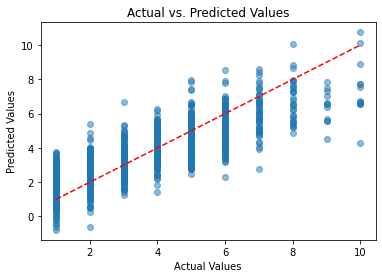

In [33]:

# Create a new scaler object for the 'R' column only
r_scaler = MinMaxScaler()

# Fit the scaler object to the scaled 'R' column data
r_scaler.fit(mainDF['Rank'].values.reshape(-1, 1))

# Get the predicted values for the training data
y_pred_train = model4.predict(sm.add_constant(X_train))

# Inverse scale the actual and predicted values
y_train_unscaled = r_scaler.inverse_transform(y_train.to_numpy().reshape(-1, 1))
y_pred_train_unscaled = r_scaler.inverse_transform(y_pred_train.to_numpy().reshape(-1, 1))

# Create a scatter plot comparing the actual and predicted unscaled values
plt.scatter(y_train_unscaled, y_pred_train_unscaled, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')

# Plot a diagonal line representing a perfect fit (actual values equal predicted values)
plt.plot([min(y_train_unscaled), max(y_train_unscaled)], [min(y_train_unscaled), max(y_train_unscaled)], color='red', linestyle='--')

# Save the plot as a PNG file
plt.savefig('model1_accuracy.png')

plt.show()



In [34]:
# Convert X_filtered to a numpy array
X_filtered_np = X_filtered.values

# Set up k-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True)

# Initialize a list to store the R^2 values for each fold
r2_values = []

# Loop over the folds
for train_index, test_index in kfold.split(X_filtered_np):
    # Split the data into training and testing sets
    X_train, X_test = X_filtered_np[train_index], X_filtered_np[test_index]
    y_train, y_test = y.iloc[train_index].reset_index(drop=True), y.iloc[test_index].reset_index(drop=True)
    
    
    X_train = pd.DataFrame(X_train, columns=X_filtered.columns)
    X_test = pd.DataFrame(X_test, columns=X_filtered.columns)
    
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    # Train a linear regression model on the training data
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Evaluate the model on the testing data and store the R^2 value
    r2 = model.score(X_test, y_test)
    
    # Check if r2 is a valid value
    if np.isnan(r2) or np.isinf(r2):
        continue
        
    r2_values.append(r2)

# Compute the mean R^2 value across all folds
mean_r2 = np.mean(r2_values)
print("Mean R^2:", mean_r2)
print("\n\n\n")

Mean R^2: 0.6768737807302216






In [35]:
# Get the coefficients and feature names
coef = model4.params
feature_names = X_filtered.columns

# Add a dummy feature name for the intercept term
feature_names = ['intercept'] + list(feature_names)

# Create a DataFrame with the coefficients and feature names
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coef': coef
})

# Add a column with the absolute value of the coefficients
coef_df['abs_coef'] = coef_df['coef'].abs()

# Sort the DataFrame by the absolute coefficient values
coef_df = coef_df.sort_values('abs_coef', ascending=False)

# Print the resulting DataFrame
print(coef_df)

         feature      coef  abs_coef
ER            ER -3.147642  3.147642
ERA          ERA  2.188375  2.188375
SLG          SLG -2.161953  2.161953
RA            RA  1.733721  1.733721
R              R -1.527025  1.527025
HR            HR  0.883160  0.883160
TB            TB  0.653475  0.653475
OBP          OBP  0.528274  0.528274
H              H  0.526493  0.526493
const  intercept  0.239897  0.239897
3B            3B  0.236053  0.236053
SV            SV -0.234026  0.234026
HA            HA  0.212557  0.212557
2B            2B  0.205325  0.205325
SB            SB -0.167213  0.167213
CS            CS  0.111888  0.111888
SF            SF  0.087460  0.087460


In [36]:
coef

const    0.239897
R       -1.527025
H        0.526493
2B       0.205325
3B       0.236053
HR       0.883160
SB      -0.167213
CS       0.111888
SF       0.087460
RA       1.733721
ER      -3.147642
ERA      2.188375
SV      -0.234026
HA       0.212557
OBP      0.528274
TB       0.653475
SLG     -2.161953
dtype: float64

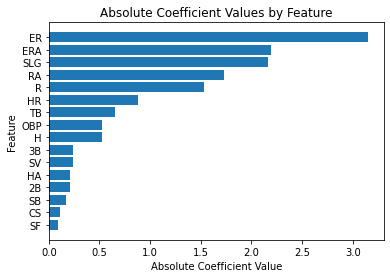

In [37]:
# Sort the values by absolute value in descending order
sorted_df = coef_df['abs_coef'].sort_values(ascending=True)

if 'const' in sorted_df.index:
    sorted_df = sorted_df.drop('const')
if 'G' in sorted_df.index:
    sorted_df = sorted_df.drop('G')

# Plot the values in a horizontal bar graph
plt.barh(sorted_df.index, sorted_df)

# Add labels and title
plt.xlabel('Absolute Coefficient Value')
plt.title('Absolute Coefficient Values by Feature')
plt.ylabel('Feature')

plt.savefig('model1_coefs.png')

# Display the plot
plt.show()

### Model 2: Predicting Number of Wins using OLS

In [38]:
# Define the features and target variables
# Dropping colinear columns contained within aggregate columns
X = scaledDF.drop(['WSWin', 'LgWin', 'Rank', 'L', 'W', 'TB', 'H', 'ERA', 'SV', 'R', 'ER', 
                   'OPS', 'SLG', 'OBP', 'G', 'AB', 'RA', 'HRA', 'E', 'HA'], axis=1)
y = scaledDF['W']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [39]:
X.T

,0,1,2,3,4,5,6,7,8,9,...,1718,1719,1720,1721,1722,1723,1724,1725,1726,1727
2B,0.494170,0.486167,0.360735,0.384193,0.313751,0.359114,0.291672,0.406893,0.310335,0.306023,...,0.504795,0.421381,0.476439,0.373603,0.526183,0.438354,0.524044,0.378432,0.612840,0.501414
3B,0.397584,0.431302,0.387097,0.762910,0.566706,0.372760,0.371698,0.394929,0.640913,0.548387,...,0.245719,0.385637,0.186778,0.069030,0.255542,0.198991,0.369972,0.245719,0.106332,0.182530
HR,0.396552,0.569615,0.328740,0.196653,0.271606,0.213245,0.372385,0.267782,0.544763,0.382484,...,0.599697,0.330977,0.489973,0.574556,0.744553,0.549704,0.629346,0.488999,0.856586,0.516304
BB,0.962000,0.656000,0.580000,0.642000,0.404000,0.280000,0.662000,0.586000,0.792000,0.660000,...,0.578000,0.508000,0.622000,0.520000,0.654000,0.406000,0.620000,0.316000,0.442000,0.596000
SO,0.176664,0.221857,0.195563,0.119145,0.220214,0.162695,0.207888,0.119967,0.201315,0.138044,...,0.840592,0.779786,0.776500,0.914544,0.889071,0.790468,0.955629,0.823336,0.689400,0.759244
SB,0.021341,0.231707,0.204268,0.262195,0.152439,0.094512,0.118902,0.073171,0.128049,0.198171,...,0.195122,0.143293,0.295732,0.155488,0.161585,0.231707,0.228659,0.283537,0.207317,0.131098
CS,0.113043,0.539130,0.226087,0.539130,0.191304,0.278261,0.234783,0.226087,0.226087,0.269565,...,0.095652,0.191304,0.269565,0.139130,0.052174,0.121739,0.295652,0.182609,0.104348,0.156522
HBP,0.388602,0.388602,0.388602,0.388602,0.388602,0.388602,0.388602,0.388602,0.388602,0.388602,...,0.612245,0.428571,0.551020,0.663265,0.581633,0.806122,0.663265,0.520408,0.448980,0.785714
SF,0.456710,0.456710,0.456710,0.456710,0.456710,0.456710,0.456710,0.456710,0.456710,0.456710,...,0.423729,0.322034,0.474576,0.305085,0.203390,0.440678,0.389831,0.220339,0.288136,0.220339
BBA,0.621013,0.527205,0.613508,0.527205,0.570356,0.416510,0.579737,0.626642,0.401501,0.551595,...,0.452158,0.634146,0.465291,0.407129,0.277674,0.637899,0.315197,0.459662,0.384615,0.525328


In [40]:
X_train = X_train.reset_index(drop=True)
# Fit a linear regression model using OLS
model1 = sm.OLS(y_train, sm.add_constant(X_train)).fit()

In [41]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      W   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     115.9
Date:                Mon, 20 Mar 2023   Prob (F-statistic):          2.19e-220
Time:                        12:59:21   Log-Likelihood:                 1140.7
No. Observations:                1382   AIC:                            -2251.
Df Residuals:                    1367   BIC:                            -2173.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1319      0.026      5.128      0.000       0.081       0.182
2B            -0.1960      0.028     -6.903      0.000      -0.252      -0.140
3B             0.1140      0.022      5.109      0.000       0.070       0.158
HR             0.2993      0.027     11.191      0.000       0.247       0.352
BB             0.3700      0.022     16.744      0.000       0.327       0.413
SO            -0.2504      0.033     -7.538      0.000      -0.316      -0.185
SB             0.2023      0.035      5.810      0.000       0.134       0.271
CS            -0.0264      0.031     -0.848      0.397      -0.087       0.035
HBP            0.0552      0.023      2.429      0.015       0.011       0.100
SF             0.1071      0.024      4.424      0.000       0.060       0.155
BBA           -0.4251      0.024    -17.820      0.000      -0.472      -0.378
SOA            0.2898      0.036      7.974      0.000       0.218       0.361
DP             0.0556      0.026      2.152      0.032       0.005       0.106
FP             0.1852      0.024      7.874      0.000       0.139       0.231
1B             0.2279      0.035      6.432      0.000       0.158       0.297
==============================================================================
Omnibus:                        0.175   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.916   Jarque-Bera (JB):                0.243
Skew:                          -0.009   Prob(JB):                        0.885
Kurtosis:                       2.938   Cond. No.                         35.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
# Removing high p-value features
# Get the p-values of the coefficients
p_values = model1.pvalues

# Filter the features based on p-values (over 0.05)
significant_features = p_values[p_values <= 0.05].index

# Drop the 'const' column if it exists
if 'const' in significant_features:
    significant_features = significant_features.drop('const')

# Create a new X matrix with only the significant features
X_filtered = X[significant_features]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2)


X_train = pd.DataFrame(X_train, columns=X_filtered.columns)
X_test = pd.DataFrame(X_test, columns=X_filtered.columns)

y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


# Print the resulting DataFrame
print(X_filtered.columns)

Index(['2B', '3B', 'HR', 'BB', 'SO', 'SB', 'HBP', 'SF', 'BBA', 'SOA', 'DP',
       'FP', '1B'],
      dtype='object')


In [43]:
X_train = X_train.reset_index(drop=True)
model2 = sm.OLS(y_train, sm.add_constant(X_train)).fit()

In [44]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      W   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     122.8
Date:                Mon, 20 Mar 2023   Prob (F-statistic):          1.02e-218
Time:                        12:59:21   Log-Likelihood:                 1144.1
No. Observations:                1382   AIC:                            -2260.
Df Residuals:                    1368   BIC:                            -2187.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1223      0.025      4.951      0.000       0.074       0.171
2B            -0.1877      0.028     -6.692      0.000      -0.243      -0.133
3B             0.1203      0.022      5.396      0.000       0.077       0.164
HR             0.3238      0.026     12.373      0.000       0.272       0.375
BB             0.3534      0.022     16.168      0.000       0.311       0.396
SO            -0.2481      0.032     -7.678      0.000      -0.311      -0.185
SB             0.1712      0.025      6.844      0.000       0.122       0.220
HBP            0.0321      0.022      1.429      0.153      -0.012       0.076
SF             0.1220      0.025      4.970      0.000       0.074       0.170
BBA           -0.4222      0.024    -17.650      0.000      -0.469      -0.375
SOA            0.2991      0.036      8.226      0.000       0.228       0.370
DP             0.0663      0.026      2.562      0.011       0.016       0.117
FP             0.1812      0.024      7.563      0.000       0.134       0.228
1B             0.2143      0.035      6.127      0.000       0.146       0.283
==============================================================================
Omnibus:                        0.116   Durbin-Watson:                   2.085
Prob(Omnibus):                  0.944   Jarque-Bera (JB):                0.164
Skew:                          -0.016   Prob(JB):                        0.921
Kurtosis:                       2.958   Cond. No.                         34.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [45]:
# Removing high p-value features
# Get the p-values of the coefficients
p_values = model2.pvalues

# Filter the features based on p-values
significant_features = p_values[p_values <= 0.05].index

# Drop the 'const' column if it exists
if 'const' in significant_features:
    significant_features = significant_features.drop('const')

# Create a new X matrix with only the significant features
X_filtered = X[significant_features]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2)


X_train = pd.DataFrame(X_train, columns=X_filtered.columns)
X_test = pd.DataFrame(X_test, columns=X_filtered.columns)

y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


# Print the resulting DataFrame
print(X_filtered.columns)

Index(['2B', '3B', 'HR', 'BB', 'SO', 'SB', 'SF', 'BBA', 'SOA', 'DP', 'FP',
       '1B'],
      dtype='object')


In [46]:
X_train = X_train.reset_index(drop=True)
model3 = sm.OLS(y_train, sm.add_constant(X_train)).fit()

In [47]:
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      W   R-squared:                       0.539
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     133.5
Date:                Mon, 20 Mar 2023   Prob (F-statistic):          2.78e-220
Time:                        12:59:21   Log-Likelihood:                 1160.7
No. Observations:                1382   AIC:                            -2295.
Df Residuals:                    1369   BIC:                            -2227.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1343      0.024      5.618      0.000       0.087       0.181
2B            -0.1879      0.027     -6.897      0.000      -0.241      -0.134
3B             0.1037      0.022      4.741      0.000       0.061       0.147
HR             0.3208      0.025     12.600      0.000       0.271       0.371
BB             0.3613      0.022     16.629      0.000       0.319       0.404
SO            -0.2622      0.032     -8.223      0.000      -0.325      -0.200
SB             0.1844      0.025      7.488      0.000       0.136       0.233
SF             0.1067      0.024      4.524      0.000       0.060       0.153
BBA           -0.3801      0.023    -16.372      0.000      -0.426      -0.335
SOA            0.2928      0.036      8.219      0.000       0.223       0.363
DP             0.0604      0.025      2.412      0.016       0.011       0.110
FP             0.1997      0.024      8.495      0.000       0.154       0.246
1B             0.1968      0.033      5.882      0.000       0.131       0.262
==============================================================================
Omnibus:                        1.359   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.507   Jarque-Bera (JB):                1.365
Skew:                          -0.076   Prob(JB):                        0.505
Kurtosis:                       2.982   Cond. No.                         33.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
# Removing high p-value features
# Get the p-values of the coefficients
p_values = model3.pvalues

# Filter the features based on p-values
significant_features = p_values[p_values <= 0.05].index

# Drop the 'const' column if it exists
if 'const' in significant_features:
    significant_features = significant_features.drop('const')

# Create a new X matrix with only the significant features
X_filtered = X[significant_features]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2)


X_train = pd.DataFrame(X_train, columns=X_filtered.columns)
X_test = pd.DataFrame(X_test, columns=X_filtered.columns)

y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


# Print the resulting DataFrame
print(X_filtered.columns)

Index(['2B', '3B', 'HR', 'BB', 'SO', 'SB', 'SF', 'BBA', 'SOA', 'DP', 'FP',
       '1B'],
      dtype='object')


In [49]:
X_train = X_train.reset_index(drop=True)
model4 = sm.OLS(y_train, sm.add_constant(X_train)).fit()

In [50]:
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      W   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.531
Method:                 Least Squares   F-statistic:                     131.4
Date:                Mon, 20 Mar 2023   Prob (F-statistic):          8.07e-218
Time:                        12:59:21   Log-Likelihood:                 1137.2
No. Observations:                1382   AIC:                            -2248.
Df Residuals:                    1369   BIC:                            -2180.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1284      0.024      5.343      0.000       0.081       0.176
2B            -0.1926      0.028     -6.851      0.000      -0.248      -0.137
3B             0.1081      0.023      4.776      0.000       0.064       0.152
HR             0.3031      0.026     11.631      0.000       0.252       0.354
BB             0.3856      0.022     17.377      0.000       0.342       0.429
SO            -0.2332      0.033     -7.067      0.000      -0.298      -0.168
SB             0.1571      0.025      6.313      0.000       0.108       0.206
SF             0.1282      0.024      5.294      0.000       0.081       0.176
BBA           -0.4114      0.024    -17.172      0.000      -0.458      -0.364
SOA            0.3140      0.037      8.523      0.000       0.242       0.386
DP             0.0571      0.026      2.228      0.026       0.007       0.107
FP             0.1852      0.024      7.703      0.000       0.138       0.232
1B             0.1976      0.034      5.763      0.000       0.130       0.265
==============================================================================
Omnibus:                        4.396   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.111   Jarque-Bera (JB):                3.795
Skew:                           0.050   Prob(JB):                        0.150
Kurtosis:                       2.764   Cond. No.                         34.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [51]:
# Convert X_filtered to a numpy array
X_filtered_np = X_filtered.values

# Set up k-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True)

# Initialize a list to store the R^2 values for each fold
r2_values = []

# Loop over the folds
for train_index, test_index in kfold.split(X_filtered_np):
    # Split the data into training and testing sets
    X_train, X_test = X_filtered_np[train_index], X_filtered_np[test_index]
    y_train, y_test = y.iloc[train_index].reset_index(drop=True), y.iloc[test_index].reset_index(drop=True)
    
    
    X_train = pd.DataFrame(X_train, columns=X_filtered.columns)
    X_test = pd.DataFrame(X_test, columns=X_filtered.columns)
    
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    # Train a linear regression model on the training data
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Evaluate the model on the testing data and store the R^2 value
    r2 = model.score(X_test, y_test)
    
    # Check if r2 is a valid value
    if np.isnan(r2) or np.isinf(r2):
        continue
        
    r2_values.append(r2)

# Compute the mean R^2 value across all folds
mean_r2 = np.mean(r2_values)
print("Mean R^2:", mean_r2)
print("\n\n\n")

Mean R^2: 0.5222015890637897






In [52]:
# Get the coefficients and feature names
coef = model4.params
feature_names = X_filtered.columns

# Add a dummy feature name for the intercept term
feature_names = ['intercept'] + list(feature_names)

# Create a DataFrame with the coefficients and feature names
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coef': coef
})

# Add a column with the absolute value of the coefficients
coef_df['abs_coef'] = coef_df['coef'].abs()

# Sort the DataFrame by the absolute coefficient values
coef_df = coef_df.sort_values('abs_coef', ascending=False)

# Print the resulting DataFrame
print(coef_df)

         feature      coef  abs_coef
BBA          BBA -0.411383  0.411383
BB            BB  0.385599  0.385599
SOA          SOA  0.313989  0.313989
HR            HR  0.303129  0.303129
SO            SO -0.233224  0.233224
1B            1B  0.197581  0.197581
2B            2B -0.192635  0.192635
FP            FP  0.185188  0.185188
SB            SB  0.157089  0.157089
const  intercept  0.128413  0.128413
SF            SF  0.128206  0.128206
3B            3B  0.108062  0.108062
DP            DP  0.057073  0.057073


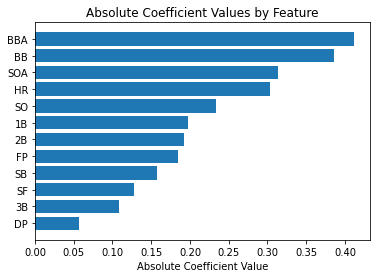

In [53]:
# Sort the values by absolute value in descending order
if 'const' in coef_df.index:
    sorted_df = coef_df['abs_coef'].drop(['const']).sort_values(ascending=True)
elif 'G' in coef_df.index:
    sorted_df = coef_df['abs_coef'].drop(['G']).sort_values(ascending=True)
else:
    sorted_df = coef_df['abs_coef'].sort_values(ascending=True)

# Plot the values in a horizontal bar graph
plt.barh(sorted_df.index, sorted_df)

# Add labels and title
plt.xlabel('Absolute Coefficient Value')
plt.title('Absolute Coefficient Values by Feature')

# Display the plot
plt.show()

## Model 3: Predicting Wins Using Random Forest

In [54]:
# Split data into train and test sets (not using scaledDF)
X_filtered = factoredDF[X_filtered.columns]
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.25, random_state=1)

# Initialize and train Random Forest model
rf = RandomForestRegressor(n_estimators=100, max_depth=20)
rf.fit(X_train, y_train)

# Make predictions on test set
y_pred = rf.predict(X_test)

# Evaluate model performance
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print('Random Forest Model Performance:')
print(f'R-squared value: {r2:.3f}')
print(f'Mean Absolute Error: {mae:.2f}')

Random Forest Model Performance:
R-squared value: 0.515
Mean Absolute Error: 0.09


In [55]:
# Print feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
print('Random Forest Feature Importances:')
for f in range(X_filtered.shape[1]):
    print(f'{f+1}. {X_filtered.columns[indices[f]]}: {importances[indices[f]]:.3f}')

Random Forest Feature Importances:
1. BBA: 0.195
2. BB: 0.180
3. HR: 0.121
4. 1B: 0.096
5. SOA: 0.065
6. 2B: 0.064
7. SB: 0.054
8. SO: 0.052
9. FP: 0.049
10. 3B: 0.044
11. SF: 0.040
12. DP: 0.040


In [56]:
X_filtered.columns

Index(['2B', '3B', 'HR', 'BB', 'SO', 'SB', 'SF', 'BBA', 'SOA', 'DP', 'FP',
       '1B'],
      dtype='object')

## Model 3b: Random Forest with 152 estimators and max_depth of 111

In [57]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.25)

# Initialize and train Random Forest model
rf2 = RandomForestRegressor(n_estimators=152, max_depth=111, min_samples_leaf=3)
rf2.fit(X_train, y_train)

# Make predictions on test set
y_pred = rf2.predict(X_test)

# Evaluate model performance
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print('Random Forest Model Performance:')
print(f'R-squared value: {r2:.3f}')
print(f'Mean Absolute Error: {mae:.2f}')

Random Forest Model Performance:
R-squared value: 0.494
Mean Absolute Error: 0.09


In [58]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.25)

# Initialize Random Forest model
rf2 = RandomForestRegressor(n_estimators=152, max_depth=111, min_samples_leaf=3)

# Perform cross-validation
cv_scores = cross_val_score(rf2, X_train, y_train, cv=5, scoring='r2')

# Train the model on the entire training set
rf2.fit(X_train, y_train)

# Make predictions on test set
y_pred = rf2.predict(X_test)


# Print cross-validation scores
print(f'Cross-Validation R-squared scores: {cv_scores}')
print(f'Mean Cross-Validation R-squared score: {np.mean(cv_scores):.3f}')
print(f'Standard Deviation of Cross-Validation R-squared scores: {np.std(cv_scores):.3f}')

Cross-Validation R-squared scores: [0.41713665 0.4744553  0.4580002  0.50882629 0.50486405]
Mean Cross-Validation R-squared score: 0.473
Standard Deviation of Cross-Validation R-squared scores: 0.034


In [59]:
# Print feature importances
importances = rf2.feature_importances_
indices = np.argsort(importances)[::-1]
print('Random Forest Feature Importances:')
for f in range(X_filtered.shape[1]):
    print(f'{f+1}. {X_filtered.columns[indices[f]]}: {importances[indices[f]]:.3f}')

Random Forest Feature Importances:
1. BBA: 0.202
2. BB: 0.171
3. HR: 0.143
4. 1B: 0.118
5. FP: 0.053
6. SB: 0.051
7. SOA: 0.051
8. 2B: 0.048
9. SO: 0.047
10. 3B: 0.044
11. SF: 0.038
12. DP: 0.035


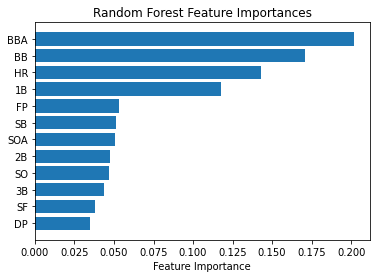

In [60]:
# Create a DataFrame to store feature importances
feat_imp = pd.DataFrame({'Feature': X_filtered.columns[indices], 'Importance': importances[indices]})

# Sort the values by importance in ascending order
feat_imp = feat_imp.sort_values('Importance', ascending=True)

# Plot the feature importances in a horizontal bar graph
plt.barh(feat_imp['Feature'], feat_imp['Importance'])

# Add labels and title
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importances')

# Display the plot
plt.show()


## Model 4: Predicting number of runs using OLS (Strictly using atomic batting statistics)
<ul>
    <li>Singles</li>
    <li>Doubles</li>
    <li>Triples</li>
    <li>Homeruns</li>
    <li>Walks</li>
</ul>

In [61]:
# Note that starting index for 2007 is 1308... This report will use train_index=1308 as the train/test split
Teams.loc[Teams['yearID'] == 2007].head(1)

,yearID,lgID,teamID,franchID,divID,Rank,G,Ghome,W,L,...,BPF,PPF,teamIDBR,teamIDlahman45,teamIDretro,OBP,TB,SLG,OPS,1B
1308,2007,NL,ARI,ARI,W,1,162,81.0,90,72,...,107,107,ARI,ARI,ARI,0.320761,2229,0.412931,0.733692,853


In [62]:
# Define the features and target variables
# Dropping colinear columns contained within aggregate columns
X = scaledDF.drop(['WSWin', 'LgWin', 'Rank', 'L', 'W', 'TB', 'H', 'ERA', 'SV', 'R', 'ER', 
                   'OPS', 'SLG', 'OBP', 'G', 'AB', 'RA', 'HRA', 'E', 'HA', 
                   'DP', 'SOA', 'FP', 'BBA', 'SO', 'HBP', 'SF', 'SB', 'CS'], axis=1)
y = scaledDF['R']

# Split the data into training and testing sets
train_idx = 1308
X_train, X_test = X.iloc[:train_idx, :], X.iloc[train_idx:, :]
y_train, y_test = y.iloc[:train_idx], y.iloc[train_idx:]

# Print the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1308, 5)
X_test shape: (420, 5)
y_train shape: (1308,)
y_test shape: (420,)


In [63]:
# Fit a linear regression model using OLS
model1 = sm.OLS(y_train, sm.add_constant(X_train)).fit()

In [64]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      R   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     3451.
Date:                Mon, 20 Mar 2023   Prob (F-statistic):               0.00
Time:                        12:59:29   Log-Likelihood:                 2567.7
No. Observations:                1308   AIC:                            -5123.
Df Residuals:                    1302   BIC:                            -5092.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1589      0.005    -30.197      0.000      -0.169      -0.149
2B             0.2299      0.008     29.528      0.000       0.215       0.245
3B             0.1006      0.007     14.436      0.000       0.087       0.114
HR             0.4296      0.008     53.460      0.000       0.414       0.445
BB             0.1898      0.007     28.234      0.000       0.177       0.203
1B             0.3412      0.010     35.555      0.000       0.322       0.360
==============================================================================
Omnibus:                       50.281   Durbin-Watson:                   1.683
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               63.912
Skew:                           0.403   Prob(JB):                     1.32e-14
Kurtosis:                       3.722   Cond. No.                         16.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [65]:
# Dropping `CS` (Caught Stealing) due to high p value
# X = X.drop('CS', axis=1)

In [66]:
# Split the data into training and testing sets
train_idx = 1308
X_train, X_test = X.iloc[:train_idx, :], X.iloc[train_idx:, :]
y_train, y_test = y.iloc[:train_idx], y.iloc[train_idx:]

# Print the shapes of the resulting datasets (note there is 1 less column than last model)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1308, 5)
X_test shape: (420, 5)
y_train shape: (1308,)
y_test shape: (420,)


In [67]:
# Fit a linear regression model using OLS
model2 = sm.OLS(y_train, sm.add_constant(X_train)).fit()

In [68]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      R   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     3451.
Date:                Mon, 20 Mar 2023   Prob (F-statistic):               0.00
Time:                        12:59:29   Log-Likelihood:                 2567.7
No. Observations:                1308   AIC:                            -5123.
Df Residuals:                    1302   BIC:                            -5092.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1589      0.005    -30.197      0.000      -0.169      -0.149
2B             0.2299      0.008     29.528      0.000       0.215       0.245
3B             0.1006      0.007     14.436      0.000       0.087       0.114
HR             0.4296      0.008     53.460      0.000       0.414       0.445
BB             0.1898      0.007     28.234      0.000       0.177       0.203
1B             0.3412      0.010     35.555      0.000       0.322       0.360
==============================================================================
Omnibus:                       50.281   Durbin-Watson:                   1.683
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               63.912
Skew:                           0.403   Prob(JB):                     1.32e-14
Kurtosis:                       3.722   Cond. No.                         16.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [69]:
# Initialize KFold cross-validator
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the R-squared scores array
r2_scores = []

# Perform cross-validation
for train_index, val_index in kfold.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Train the OLS model
    model2 = sm.OLS(y_train_fold, sm.add_constant(X_train_fold)).fit()

    # Make predictions on validation set
    y_pred_fold = model2.predict(sm.add_constant(X_val_fold))

    # Calculate the R-squared score for the current fold
    r2_fold = r2_score(y_val_fold, y_pred_fold)

    # Append the R-squared score to the scores array
    r2_scores.append(r2_fold)

# Convert the R-squared scores array to a NumPy array
r2_scores = np.array(r2_scores)

# Print cross-validation scores
print(f'Cross-Validation R-squared scores: {r2_scores}')
print(f'Mean Cross-Validation R-squared score: {np.mean(r2_scores):.3f}')
print(f'Standard Deviation of Cross-Validation R-squared scores: {np.std(r2_scores):.3f}')

Cross-Validation R-squared scores: [0.91828213 0.9228204  0.93890246 0.93206771 0.92965897]
Mean Cross-Validation R-squared score: 0.928
Standard Deviation of Cross-Validation R-squared scores: 0.007


In [70]:
# Get the coefficients and feature names
coef = model2.params
feature_names = X.columns

# Add a dummy feature name for the intercept term
feature_names = ['intercept'] + list(feature_names)

# Create a DataFrame with the coefficients and feature names
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coef': coef
})

# Add a column with the absolute value of the coefficients
coef_df['abs_coef'] = coef_df['coef'].abs()

# Sort the DataFrame by the absolute coefficient values
coef_df = coef_df.sort_values('abs_coef', ascending=False)

# Print the resulting DataFrame
print(coef_df)

         feature      coef  abs_coef
HR            HR  0.427772  0.427772
1B            1B  0.339447  0.339447
2B            2B  0.228975  0.228975
BB            BB  0.189711  0.189711
const  intercept -0.157002  0.157002
3B            3B  0.099691  0.099691


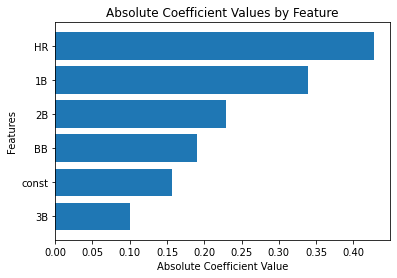

In [71]:
# Sort the values by absolute value in descending order
sorted_df = coef_df['abs_coef'].sort_values(ascending=True)

# Plot the values in a horizontal bar graph
plt.barh(sorted_df.index, sorted_df)

# Add labels and title
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Features')
plt.title('Absolute Coefficient Values by Feature')

plt.savefig('model4_coefs.png', dpi=300)

# Display the plot
plt.show()

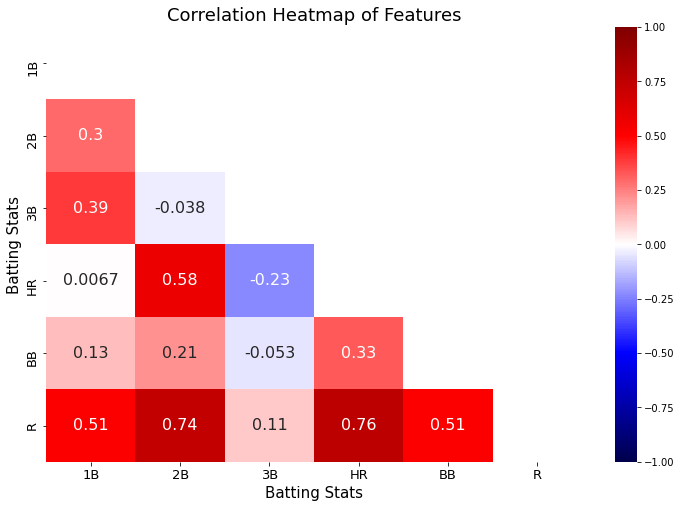

In [72]:
# Create a heatmap of the correlation matrix of selected variables
fig, ax = plt.subplots(figsize=(12,8))
corr_matrix = scaledDF[['1B', '2B', '3B', 'HR', 'BB', 'R']].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, 
            mask=mask,
            annot=True, 
            cmap='seismic', 
            vmin=-1, vmax=1,
            annot_kws={'fontsize': 16},
            ax=ax)
ax.set_title('Correlation Heatmap of Features', fontsize=18)
ax.set_xlabel('Batting Stats', fontsize=15)
ax.set_ylabel('Batting Stats', fontsize=15)
ax.tick_params(axis='x', labelsize=13)
ax.tick_params(axis='y', labelsize=13)

# Save the heatmap as an image
plt.savefig('corr_heatmap.png', dpi=300)


## Model 5: Predicting number of Runs using Random Forrest

In [73]:
# Initialize and train Random Forest model
model = RandomForestRegressor(n_estimators=192, max_depth=30, min_samples_leaf=1)
model.fit(X_train, y_train)

# Make predictions on test set
y_pred = model.predict(X_test)

# Evaluate model performance
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print('Random Forest Model Performance:')
print(f'R-squared value: {r2:.3f}')
print(f'Mean Absolute Error: {mae:.2f}')

Random Forest Model Performance:
R-squared value: 0.834
Mean Absolute Error: 0.04


In [74]:
# Print feature importances
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
print('Random Forest Feature Importances:')
for f in range(X.shape[1]):
    print(f'{f+1}. {X.columns[indices[f]]}: {importances[indices[f]]:.3f}')

Random Forest Feature Importances:
1. HR: 0.520
2. 2B: 0.230
3. 1B: 0.172
4. BB: 0.059
5. 3B: 0.020


In [75]:
# Define the parameter grid to search over
param_grid = {
    'n_estimators': [48, 192],
    'max_depth': [10, 20, 30, 40, None],
    'min_samples_leaf': [1, 2, 4],
}

# Initialize a random forest regressor object
rf = RandomForestRegressor()

# Initialize the grid search object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print(grid_search.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
{'max_depth': 30, 'min_samples_leaf': 1, 'n_estimators': 48}


In [76]:
# Initialize and train Random Forest model
model2 = RandomForestRegressor(n_estimators=192, max_depth=10, min_samples_leaf=1)
model2.fit(X_train, y_train)

# Make predictions on test set
y_pred = model2.predict(X_test)

# Evaluate model performance
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print('Random Forest Model Performance:')
print(f'R-squared value: {r2:.3f}')
print(f'Mean Absolute Error: {mae:.2f}')

Random Forest Model Performance:
R-squared value: 0.833
Mean Absolute Error: 0.04


In [77]:
# Print feature importances
importances = model2.feature_importances_
indices = np.argsort(importances)[::-1]
print('Random Forest Feature Importances:')
for f in range(X.shape[1]):
    print(f'{f+1}. {X.columns[indices[f]]}: {importances[indices[f]]:.3f}')

Random Forest Feature Importances:
1. HR: 0.531
2. 2B: 0.224
3. 1B: 0.171
4. BB: 0.057
5. 3B: 0.017


In [78]:
# Perform cross-validation
cv_scores = cross_val_score(model2, X_train, y_train, cv=5, scoring='r2')

# Train the model on the entire training set
model2.fit(X_train, y_train)

# Make predictions on test set
y_pred = model2.predict(X_test)


# Print cross-validation scores
print(f'Cross-Validation R-squared scores: {cv_scores}')
print(f'Mean Cross-Validation R-squared score: {np.mean(cv_scores):.3f}')
print(f'Standard Deviation of Cross-Validation R-squared scores: {np.std(cv_scores):.3f}')

Cross-Validation R-squared scores: [0.81955188 0.86767621 0.91130421 0.87097553 0.83318465]
Mean Cross-Validation R-squared score: 0.861
Standard Deviation of Cross-Validation R-squared scores: 0.032


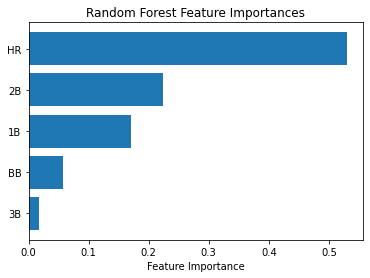

In [79]:
# Create a DataFrame to store feature importances
feat_imp = pd.DataFrame({'Feature': X.columns[indices], 'Importance': importances[indices]})

# Sort the values by importance in ascending order
feat_imp = feat_imp.sort_values('Importance', ascending=True)

# Plot the feature importances in a horizontal bar graph
plt.barh(feat_imp['Feature'], feat_imp['Importance'])

# Add labels and title
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importances')

# Display the plot
plt.show()

## Model 6: Predicting number of Runs using Polynomial Regression

In [80]:
# Transform the features into polynomial features of degree 2
poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

In [81]:
# Fit the polynomial regression model to the training data
model1 = LinearRegression().fit(X_train_poly, y_train)

In [82]:
# Use the trained model to predict the dependent variable for the testing data
y_test_pred = model1.predict(X_test_poly)

In [83]:
print('MSE:', mean_squared_error(y_test, y_test_pred))
print('R-squared:', r2_score(y_test, y_test_pred))

MSE: 0.0010219958144586858
R-squared: 0.9214490765638671


In [84]:
# Define the pipeline with the polynomial feature transformer and the Ridge regression model
pipe = Pipeline([
    ('poly', PolynomialFeatures()),
    ('reg', Ridge())
])

# Define the grid of hyperparameters to search over
param_grid = {
    'poly__degree': [1, 2, 3, 4, 5, 6, 7, 8],
    'reg__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10, 100, 1000]
}

# Run the grid search over the hyperparameters
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

# Print the best hyperparameters
print('Best hyperparameters:', grid.best_params_)

# Evaluate the performance of the best model on the testing data
y_test_pred = grid.predict(X_test)
mse = mean_squared_error(y_test, y_test_pred)
print('MSE:', mse)

Best hyperparameters: {'poly__degree': 4, 'reg__alpha': 1.0}
MSE: 0.0009509366059591138


In [85]:
# Instantiate the model with the best hyperparameters
model2 = Pipeline([
    ('poly', PolynomialFeatures(degree=4)),
    ('reg', Ridge(alpha=1.0, solver='sparse_cg'))
])

# Fit the model to the training data
model2.fit(X_train, y_train)

# Use the model to predict the dependent variable for the testing data
y_test_pred = model2.predict(X_test)

# Evaluate the performance of the model on the testing data
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
print('MSE:', mse)
print('R-squared:', r2)

MSE: 0.0009492334478313282
R-squared: 0.9270416152114004


In [86]:
# Instantiate the model with the best hyperparameters
model2 = Pipeline([
    ('poly', PolynomialFeatures(degree=4)),
    ('reg', Ridge(alpha=1, solver='sparse_cg'))
])

# Perform cross-validation
cv_scores = cross_val_score(model2, X_train, y_train, cv=5, scoring='r2')

# Fit the model to the training data
model2.fit(X_train, y_train)

# Print cross-validation scores
print(f'Cross-Validation R-squared scores: {cv_scores}')
print(f'Mean Cross-Validation R-squared score: {np.mean(cv_scores):.3f}')
print(f'Standard Deviation of Cross-Validation R-squared scores: {np.std(cv_scores):.3f}')

Cross-Validation R-squared scores: [0.87987867 0.92168527 0.94204552 0.90717915 0.92800872]
Mean Cross-Validation R-squared score: 0.916
Standard Deviation of Cross-Validation R-squared scores: 0.021


In [87]:
# Instantiate the model pipeline
model_pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
    ('reg', Ridge())
])

# Define the hyperparameter search space
param_grid = {
    'poly__degree': [3, 4],
    'poly__interaction_only': [True, False],
    'reg__alpha': [0.1, 1, 10], 
    'reg__normalize': [True, False],
    'reg__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

# Instantiate the grid search
grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Print the best combination of hyperparameters and the corresponding R-squared score
print(f'Best hyperparameters: {grid_search.best_params_}')
print(f'Best R-squared score: {grid_search.best_score_:.3f}')

# Retrieve the best model and make predictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Fitting 5 folds for each of 168 candidates, totalling 840 fits
Best hyperparameters: {'poly__degree': 4, 'poly__interaction_only': False, 'reg__alpha': 1, 'reg__normalize': False, 'reg__solver': 'sparse_cg'}
Best R-squared score: 0.916


C:\Users\jamie\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


In [88]:
# Get the coefficient estimates and their names
coef_names = ['intercept'] + list(model2.named_steps['poly'].get_feature_names(X_train.columns))[1:]
coef_values = list(model2.named_steps['reg'].coef_)

# Create a DataFrame with the coefficient values
df_coef = pd.DataFrame({'feature': coef_names, 'coef': coef_values})

C:\Users\jamie\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


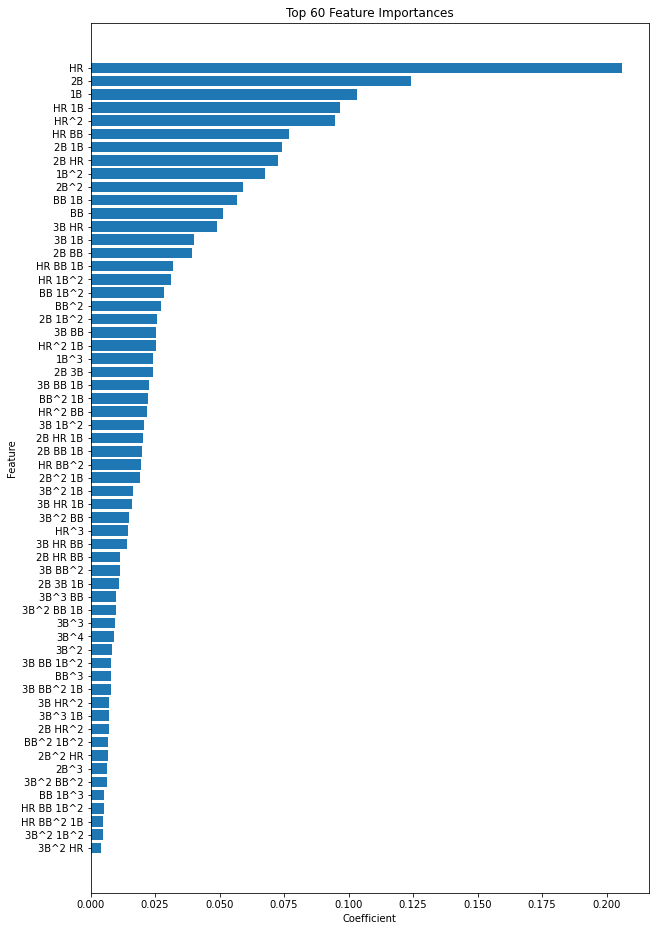

In [89]:
# Sort the feature importances in descending order
df_coef = df_coef.sort_values(by='coef', ascending=False)

# Select the top 60 feature importances
top_60 = df_coef.iloc[:60]

# Create a bar plot of the top 60 feature importances in descending order
plt.figure(figsize=(10, 16))
plt.barh(top_60['feature'], top_60['coef'])
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Top 60 Feature Importances')
plt.gca().invert_yaxis()
plt.show()

In [90]:
# sorted by absolute value
df_coef.iloc[(-df_coef['coef'].abs()).argsort()]

,feature,coef
3,HR,0.205970
1,2B,0.124288
5,1B,0.103167
17,HR 1B,0.096658
15,HR^2,0.094902
...,...,...
27,2B 3B HR,-0.000943
115,HR^2 BB 1B,-0.000688
110,3B 1B^3,0.000629
107,3B BB^3,0.000569


In [91]:
# Create an empty dictionary to store the sums for each feature
sum_dict = {}

# Loop over each feature and calculate the sum of its coefficients
for feature in ['HR', '1B', '2B', '3B', 'BB']:
    feature_sum = df_coef.loc[df_coef['feature'].str.contains(feature), 'coef'].sum()
    sum_dict[feature] = feature_sum

# Convert the dictionary to a dataframe and sort it by the sum of coefficients in descending order
sum_df = pd.DataFrame.from_dict(sum_dict, orient='index', columns=['coef_sum']).sort_values('coef_sum', ascending=False)

# Print the resulting dataframe
sum_df

,coef_sum
1B,0.665257
HR,0.456517
BB,0.410422
3B,0.111083
2B,0.088430


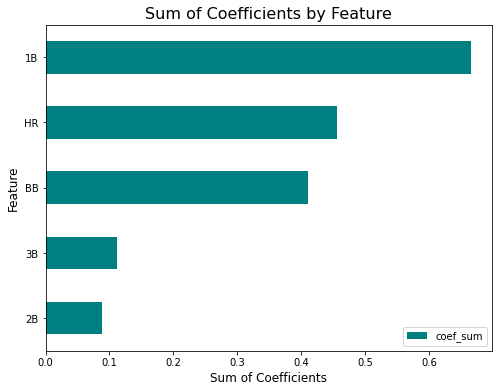

In [92]:
# Plot the sum of coefficients for each feature as a horizontal bar graph
ax = sum_df.sort_values('coef_sum').plot(kind='barh', figsize=(8,6), color='teal')

# Set the title and axis labels
ax.set_title('Sum of Coefficients by Feature', fontsize=16)
ax.set_xlabel('Sum of Coefficients', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)
plt.savefig('sumCoefs_model6.png')
# Show the plot
plt.show()


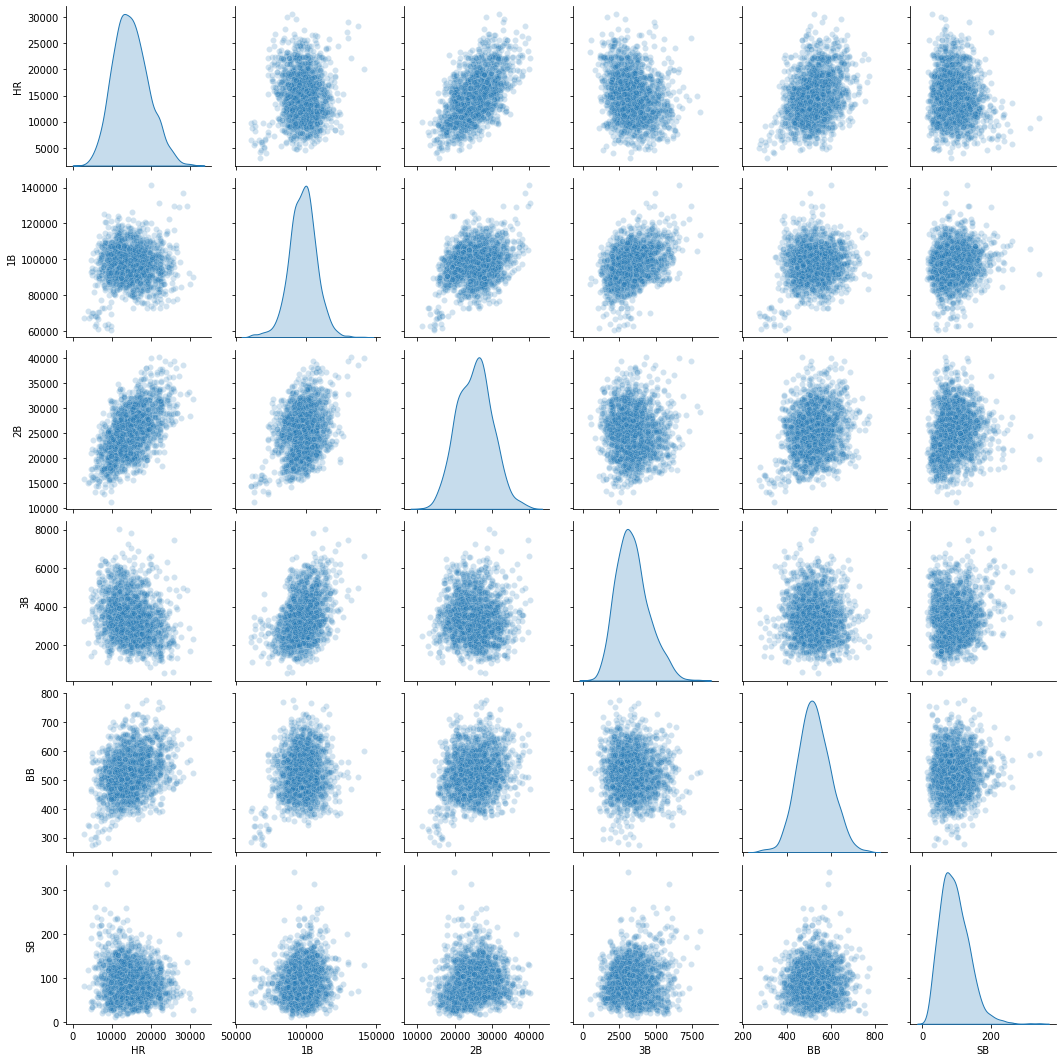

In [93]:
# Create a scatterplot matrix (note that 2B seems the least normally distributed)
# Note that doubles and singles have multple modes
sns.pairplot(factoredDF, vars=['HR', '1B', '2B', '3B', 'BB', 'SB'], diag_kind='kde', plot_kws={'alpha': 0.2})
plt.savefig('pairplot.png')

<AxesSubplot:xlabel='SF', ylabel='Count'>

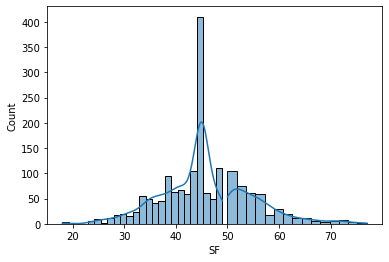

In [94]:
import matplotlib.pyplot as plt

# Split the data into two subgroups based on SF
subgroup1 = factoredDF[factoredDF.SF < 50]
subgroup2 = factoredDF[factoredDF.SF >= 50]

# Create histograms or KDE plots for each subgroup
sns.histplot(subgroup1.SF, kde=True)
sns.histplot(subgroup2.SF, kde=True)


In [95]:
indexList = factoredDF.loc[factoredDF['SF'] == 44].index.tolist()

C:\Users\jamie\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


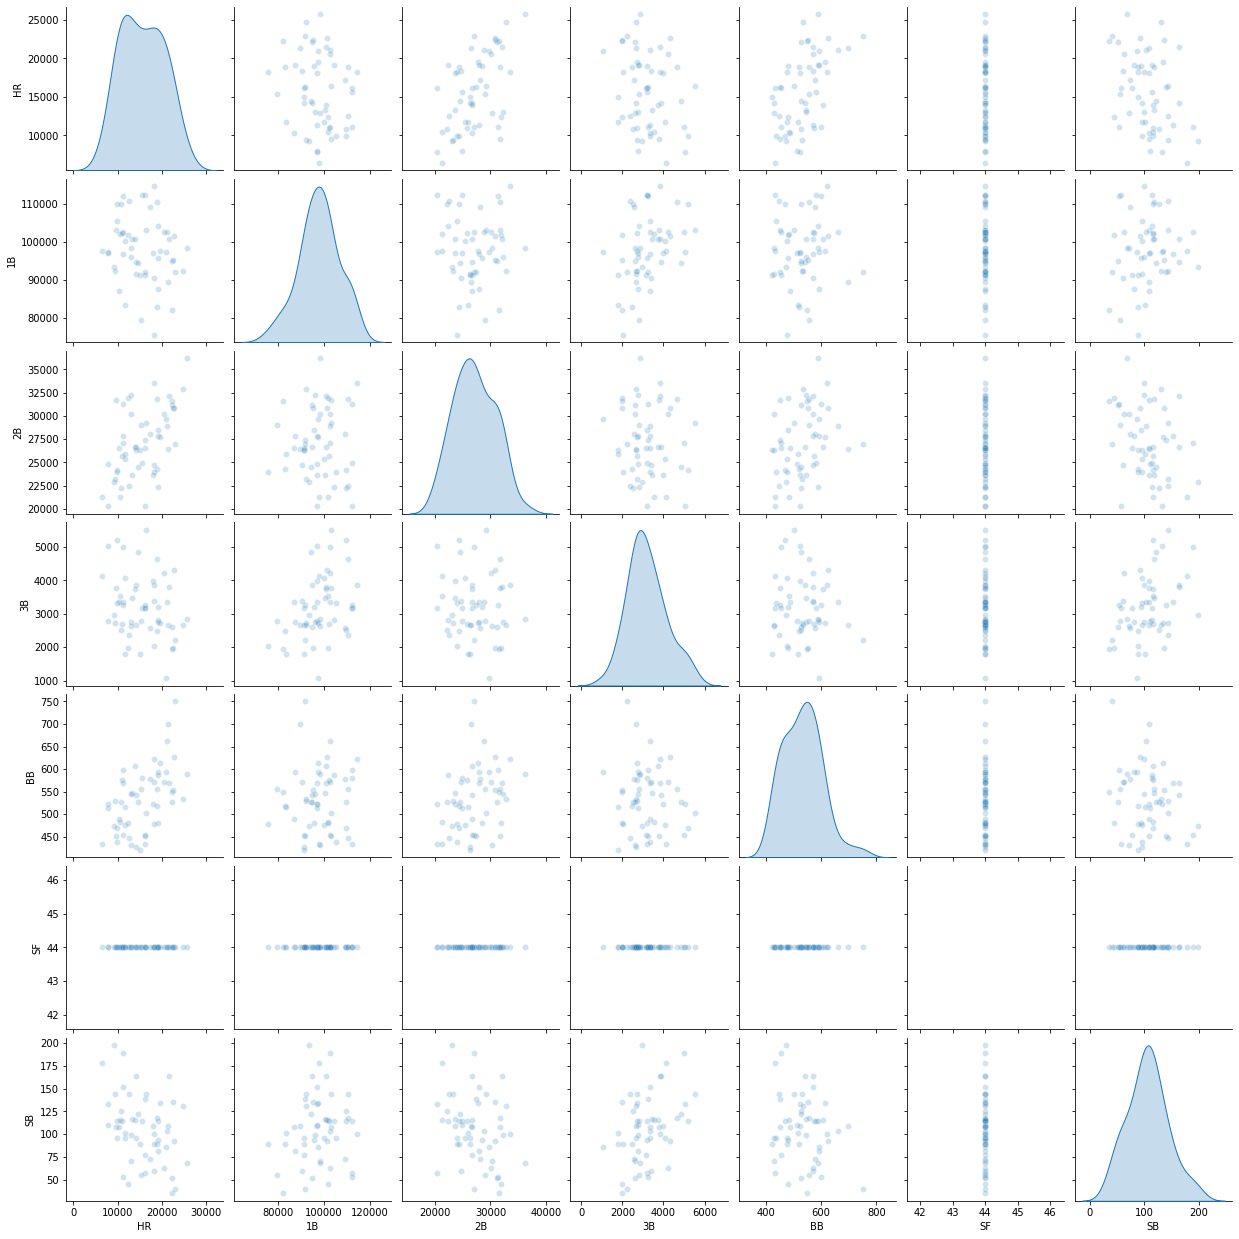

In [96]:
sns.pairplot(factoredDF.loc[indexList], vars=['HR', '1B', '2B', '3B', 'BB', 'SF', 'SB'], diag_kind='kde', plot_kws={'alpha': 0.2})
plt.savefig('pairplot_SF44.png')

In [97]:
Teams.loc[indexList]

,yearID,lgID,teamID,franchID,divID,Rank,G,Ghome,W,L,...,BPF,PPF,teamIDBR,teamIDlahman45,teamIDretro,OBP,TB,SLG,OPS,1B
366,1971,NL,ATL,ATL,W,3,162,82.0,82,80,...,106,107,ATL,ATL,ATL,0.311791,2145,0.384753,0.696544,1059
416,1973,AL,BOS,BOS,E,2,162,81.0,89,73,...,106,106,BOS,BOS,BOS,0.337818,2208,0.400508,0.738326,1060
456,1974,NL,PHI,PHI,E,3,162,81.0,80,82,...,104,104,PHI,PHI,PHI,0.319741,2052,0.373498,0.693240,1056
471,1975,NL,HOU,HOU,W,6,162,81.0,64,97,...,93,93,HOU,HOU,HOU,0.319921,1979,0.358840,0.678761,1045
521,1977,NL,LAN,LAD,W,1,162,81.0,98,64,...,100,98,LAD,LAN,LAN,0.335522,2336,0.417964,0.753486,1042
545,1978,NL,HOU,HOU,W,5,162,81.0,74,88,...,92,92,HOU,HOU,HOU,0.312857,1939,0.355258,0.668115,1062
609,1980,AL,SEA,SEA,W,7,163,81.0,59,103,...,101,103,SEA,SEA,SEA,0.308368,1952,0.355620,0.663988,1009
696,1984,AL,CHA,CHW,W,5,162,81.0,74,88,...,105,104,CHW,CHA,CHA,0.314104,2177,0.394885,0.708988,925
711,1984,NL,PIT,PIT,E,6,162,81.0,75,87,...,101,101,PIT,PIT,PIT,0.309540,2009,0.362832,0.672371,1044
714,1984,NL,SFN,SFG,W,6,162,81.0,66,96,...,97,98,SFG,SFN,SFN,0.327617,2116,0.374513,0.702130,1132


In [98]:
for col in ['HR', '1B', '2B', '3B', 'BB', 'SF', 'SB']:
    shap = shapiro(factoredDF[col])
    print(f"Col {col} SW Value: {shap}")

Col HR SW Value: ShapiroResult(statistic=0.9913772344589233, pvalue=1.4642687951038624e-08)
Col 1B SW Value: ShapiroResult(statistic=0.9896654486656189, pvalue=9.636365039256134e-10)
Col 2B SW Value: ShapiroResult(statistic=0.9971593022346497, pvalue=0.003105380805209279)
Col 3B SW Value: ShapiroResult(statistic=0.9802929162979126, pvalue=1.112468424265033e-14)
Col BB SW Value: ShapiroResult(statistic=0.9975087642669678, pvalue=0.008101841434836388)
Col SF SW Value: ShapiroResult(statistic=0.9731113314628601, pvalue=1.8339358495186623e-17)
Col SB SW Value: ShapiroResult(statistic=0.9615388512611389, pvalue=5.360696632634049e-21)


In [99]:
from sklearn import metrics

# Make predictions using the model
y_pred = model2.predict(X_test)

# Calculate the R-squared value
r2 = metrics.r2_score(y_test, y_pred)

# Calculate the MSE value
mse = metrics.mean_squared_error(y_test, y_pred)

# Calculate the RMSE value
rmse = np.sqrt(mse)

# Calculate the MAE value
mae = metrics.mean_absolute_error(y_test, y_pred)

# Print the results
print('R-squared:', r2)
print('MSE:', mse)
print('RMSE:', rmse)
print('MAE:', mae)


R-squared: 0.9270416152114004
MSE: 0.0009492334478313282
RMSE: 0.030809632387150097
MAE: 0.024626669391702084


In [100]:
# Create a KFold object with 5 folds
kf = KFold(n_splits=5, shuffle=True)

# Perform cross-validation
r2_scores = cross_val_score(model2, X, y, cv=kf, scoring='r2')
mse_scores = cross_val_score(model2, X, y, cv=kf, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-mse_scores)
mae_scores = cross_val_score(model2, X, y, cv=kf, scoring='neg_mean_absolute_error')

# Print the average scores
print('Cross-validation R-squared:', np.mean(r2_scores))
print('Cross-validation MSE:', np.mean(mse_scores))
print('Cross-validation RMSE:', np.mean(rmse_scores))
print('Cross-validation MAE:', np.mean(mae_scores))


Cross-validation R-squared: 0.9360696256209902
Cross-validation MSE: -0.000996302651693815
Cross-validation RMSE: 0.031541789299829356
Cross-validation MAE: -0.02503321673630975


In [101]:
# Create a new scaler object for the 'R' column only
r_scaler = MinMaxScaler()

# Fit the scaler object to the scaled 'R' column data
r_scaler.fit(mainDF['R'].values.reshape(-1, 1))

# Inverse transform the scaled predictions for the 'R' column only
y_pred_inv = r_scaler.inverse_transform(y_pred.reshape(-1, 1)).ravel()

# Inverse transform the scaled actual values for the 'R' column only
y_test_inv = r_scaler.inverse_transform(y_test.values.reshape(-1, 1)).ravel()


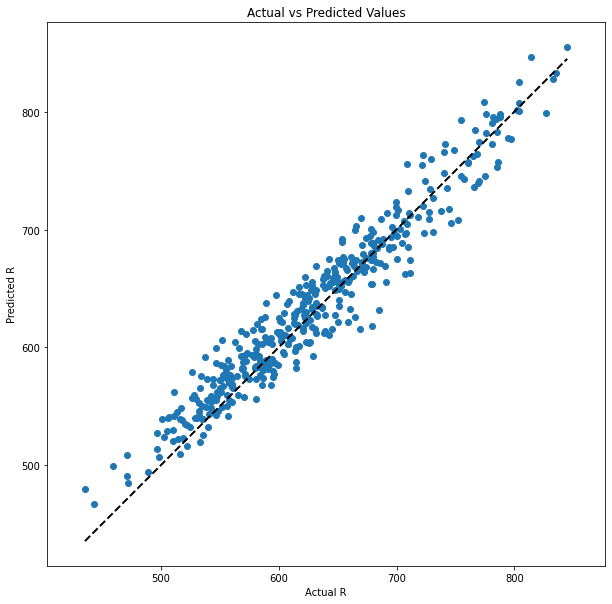

In [102]:
#Inversing the scaled predictions
y_test_inv = r_scaler.inverse_transform(y_test.values.reshape(-1, 1)).ravel()
y_pred_inv = r_scaler.inverse_transform(y_pred.reshape(-1, 1)).ravel()

# Plot the actual vs predicted values
plt.figure(figsize=(10,10))
plt.scatter(y_test_inv, y_pred_inv)
plt.plot([y_test_inv.min(), y_test_inv.max()], [y_test_inv.min(), y_test_inv.max()], 'k--', lw=2)
plt.xlabel('Actual R')
plt.ylabel('Predicted R')
plt.title('Actual vs Predicted Values')

# Set the x and y scales to be equal
plt.axis('equal')
plt.savefig('model6_accuracy.png')
plt.show()


